In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Create Temporal Network Edgelist using Arxiv Dataset
In order to convert an edgelist into a temporal edgelist, add a datetime field of some sort that you can group on. Depending on use-case, you may want this down to the minute or second. These are research papers, so I will do down to the YEARMONTH.

In [3]:
data = r'C:\Users\groov\PythonCode\100daysofnetworks\data\arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title', 'date_published']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

# make ready for temporal network analysis
df.sort_values('date_published', inplace=True)
df['date_published'] = pd.to_datetime(df['date_published'])
df['date_published'] = df['date_published'].dt.strftime('%Y%m')

df.head()

,authors,title,date_published
75477,Donald E. Knuth,Textbook examples of recursion,199108
75476,Achi Brandt,Multigrid Methods in Lattice Field Computations,199204
75474,M. Fabbrichesi,Strong Antigravity. Life in the Shock Wave,199205
75475,K. Roland,Strong Antigravity. Life in the Shock Wave,199205
75473,Rolf Schimmrigk,Noncritical Dimensions for Critical String The...,199211


# Visual Spot Check of Titles Per Year
This will give us some understanding of the patterns in this dataset.

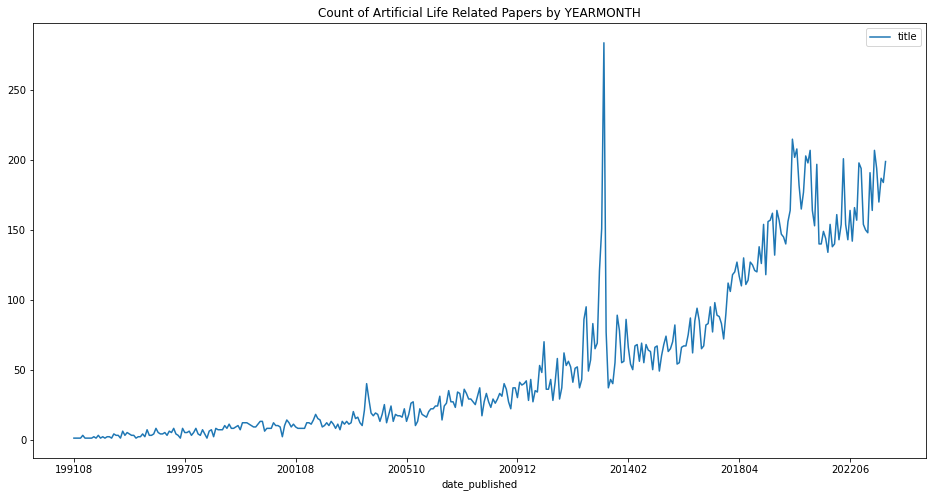

In [4]:
check_df = df[['title', 'date_published']].copy()
check_df.drop_duplicates(inplace=True)

title = 'Count of Artificial Life Related Papers by YEARMONTH'
_= check_df.groupby('date_published').count()[:-1].plot(figsize=(16,8), title=title)

# Create Dictionary of Temporal Graphs using Bipartite Projection
Using Bipartite Projectin, I can convert this mixed network into a social network, which we can explore. This requires some coding.

We explored "Network Changes" on day 13.

In [5]:
# I will use a dictionary of temporal graphs

G = {}

In [6]:
# Psuedocode

# For each YEARMONTH in df
    # Add a temporal social network to the dictionary
    
# This takes a few minutes on a large network; There is probably a way to speed this up, with some thought.

In [7]:
from networkx.algorithms import bipartite
from tqdm import tqdm

dates = sorted(set(df['date_published']))

for i in tqdm(range(len(dates))):
        
    date = dates[i]
        
    network_df = df[df['date_published']==date].copy()
    
    if network_df.shape[1] > 2:
        
        G[date] = {}
        B = nx.from_pandas_edgelist(network_df, source='authors', target='title')
        G[date]['graph'] = bipartite.projected_graph(B, network_df['authors'])

        #G[date] = nx.k_core(G[date], 2) # no isolates or two-node groups

100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:09<00:00, 39.91it/s]


In [72]:
list(G.keys())[-10:]

['202302',
 '202303',
 '202304',
 '202305',
 '202306',
 '202307',
 '202308',
 '202309',
 '202310',
 '202311']

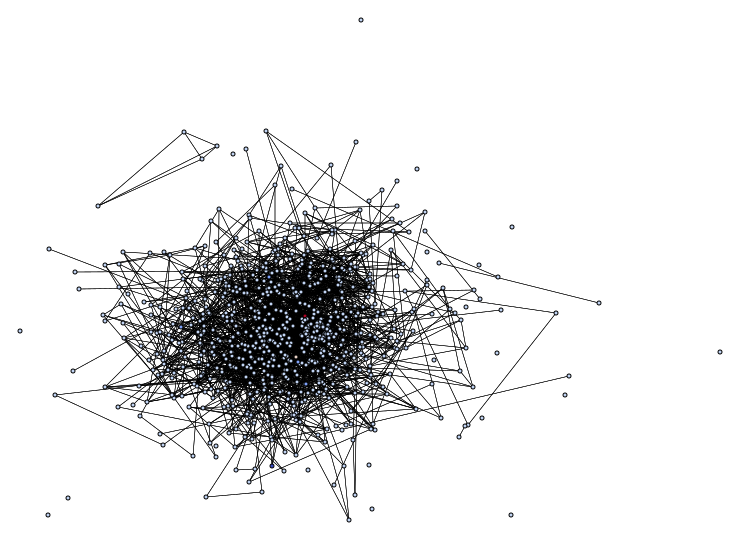

In [9]:
draw_graph(G['202306']['graph'], show_names=False, node_size=2)

# Enrich the Graph Data

In [10]:
def enrich_temporal_graph(G):
    
    i = 0
    
    G = G.copy()
            
    for key in list(G.keys()):
                
        cur_idx = list(G.keys())[i]
        
        if i > 0:
            prev_idx = i - 1
            prev_idx = list(G.keys())[prev_idx]
        else:
            prev_idx = list(G.keys())[0]
                
        if key == list(G.keys())[0]: # if first element
            G[cur_idx]['density_change'] = nx.density(G[cur_idx]['graph'])
            G[cur_idx]['degree_change'] = len(G[cur_idx]['graph'].degree)
            G[cur_idx]['edge_change'] = len(G[cur_idx]['graph'].edges)
            continue
            
        current_edges = list(G[cur_idx]['graph'].edges)
        previous_edges = list(G[prev_idx]['graph'].edges)

        current_nodes = list(G[cur_idx]['graph'].nodes)
        previous_nodes = list(G[prev_idx]['graph'].nodes)

        # edge changes
        dropped_edges = sorted([e for e in previous_edges if e not in current_edges])
        added_edges = sorted([e for e in current_edges if e not in previous_edges])
        G[cur_idx]['dropped_edges'] = dropped_edges
        G[cur_idx]['added_edges'] = added_edges

        # node changes
        dropped_nodes = sorted([n for n in previous_nodes if n not in current_nodes])
        added_nodes = sorted([n for n in current_nodes if n not in previous_nodes])
        G[cur_idx]['dropped_nodes'] = dropped_nodes
        G[cur_idx]['dropped_node_count'] = len(dropped_nodes)
        G[cur_idx]['added_nodes'] = added_nodes
        G[cur_idx]['added_node_count'] = len(added_nodes)

        # dropped parts of Graph
        G_dropped = nx.from_edgelist(dropped_edges)
        G[cur_idx]['graph_dropped'] = G_dropped

        # added parts of Graph
        G_added = nx.from_edgelist(added_edges)
        G[cur_idx]['graph_added'] = G_added

        # changes to density (could use any "Whole Network Analysis" metrics, or centralities, etc; get creative)
        density_change = nx.density(G[cur_idx]['graph']) - nx.density(G[prev_idx]['graph'])
        degree_change = len(G[cur_idx]['graph'].degree) - len(G[prev_idx]['graph'].degree)
        edge_change = len(G[cur_idx]['graph'].edges) - len(G[prev_idx]['graph'].edges)
        G[cur_idx]['density_change'] = density_change
        G[cur_idx]['degree_change'] = degree_change
        G[cur_idx]['edge_change'] = edge_change
        
        # get the core
        max_degrees = max([d[1] for d in G[cur_idx]['graph'].degree])
        cutoff_threshold=2 # for k_core; subjective
        k = max_degrees - cutoff_threshold
        
        G[cur_idx]['graph_core'] = nx.k_core(G[cur_idx]['graph'], k)
        G[cur_idx]['graph_core_node_count'] = len(G[cur_idx]['graph_core'].nodes)
        G[cur_idx]['graph_core_edge_count'] = len(G[cur_idx]['graph_core'].edges)

        i += 1
        
    return G

In [11]:
G = enrich_temporal_graph(G)

In [12]:
G['199312']

{'graph': <networkx.classes.graph.Graph at 0x25279d5c5c8>,
 'dropped_edges': [('Junji Suzuki', 'Kunihiko Kaneko'),
  ('S. T. Petcov', 'A. Yu. Smirnov')],
 'added_edges': [('B. B. Levchenko', 'C. Riccardi'),
  ('B. B. Levchenko', 'G. Boca'),
  ('B. B. Levchenko', 'G. Salvadori'),
  ('B. B. Levchenko', 'I. M. Dremin'),
  ('B. B. Levchenko', 'L. Viola'),
  ('B. B. Levchenko', 'M. Merlo'),
  ('B. B. Levchenko', 'P. Vitulo'),
  ('B. B. Levchenko', 'S. Malvezzi'),
  ('B. B. Levchenko', 'S. P. Ratti'),
  ('B. B. Levchenko', 'V. A. Nechitailo'),
  ('B. B. Levchenko', 'V. Arena'),
  ('G. Boca', 'C. Riccardi'),
  ('G. Boca', 'G. Salvadori'),
  ('G. Boca', 'I. M. Dremin'),
  ('G. Boca', 'L. Viola'),
  ('G. Boca', 'M. Merlo'),
  ('G. Boca', 'P. Vitulo'),
  ('G. Boca', 'S. Malvezzi'),
  ('G. Boca', 'S. P. Ratti'),
  ('G. Boca', 'V. A. Nechitailo'),
  ('G. Gianini', 'B. B. Levchenko'),
  ('G. Gianini', 'C. Riccardi'),
  ('G. Gianini', 'G. Boca'),
  ('G. Gianini', 'G. Salvadori'),
  ('G. Gianini', 'I

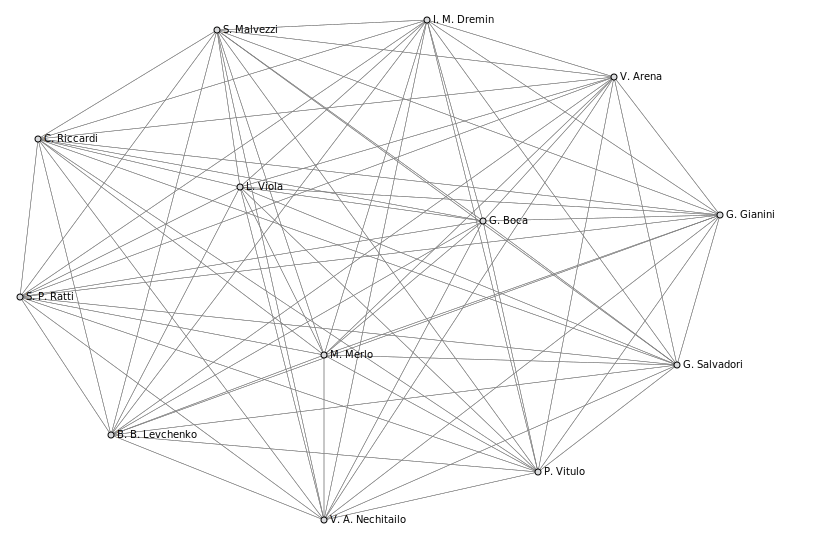

In [13]:
draw_graph(G['199312']['graph'], show_names=True, node_size=3)

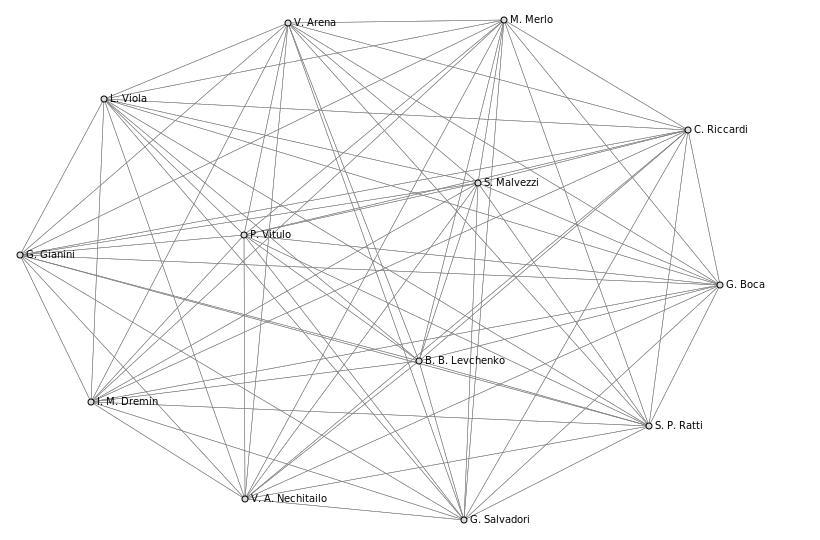

In [14]:
draw_graph(G['199312']['graph_core'], show_names=True, node_size=3)

# Burstiness By Node Count

In [92]:
result_df = pd.DataFrame(G).T

result_df.head()

,graph,density_change,degree_change,edge_change,dropped_edges,added_edges,dropped_nodes,dropped_node_count,added_nodes,added_node_count,graph_dropped,graph_added,graph_core,graph_core_node_count,graph_core_edge_count
199108,(Donald E. Knuth),0,0,0,[],[],[],0,[],0,(),(),(Donald E. Knuth),1,0
199204,(Achi Brandt),0,0,0,[],[],[Donald E. Knuth],1,[Achi Brandt],1,(),(),(Achi Brandt),1,0
199205,"(M. Fabbrichesi, K. Roland)",1.0,1,1,[],"[(M. Fabbrichesi, K. Roland)]",[Achi Brandt],1,"[K. Roland, M. Fabbrichesi]",2,(),"(M. Fabbrichesi, K. Roland)","(M. Fabbrichesi, K. Roland)",2,1
199211,(Rolf Schimmrigk),-1.0,-1,-1,"[(M. Fabbrichesi, K. Roland)]",[],"[K. Roland, M. Fabbrichesi]",2,[Rolf Schimmrigk],1,"(M. Fabbrichesi, K. Roland)",(),(Rolf Schimmrigk),1,0
199302,"(D. Nunez, J. Salim, H. P. de Oliveira, A. Pov...",0.238095,6,5,[],"[(A. Poves, G. Martinez-Pinedo), (D. Nunez, H....",[Rolf Schimmrigk],1,"[A. D. Dolgov, A. Poves, D. Nunez, G. Martinez...",7,(),"(A. Poves, G. Martinez-Pinedo, D. Nunez, H. P....","(D. Nunez, J. Salim, H. P. de Oliveira, A. Pov...",7,5


In [93]:
result_df[result_df['added_node_count'] > 800].index.values[-20:] # just a nonsense threshold to experiment

array(['202004', '202005', '202010', '202011', '202012', '202203',
       '202210', '202211', '202308'], dtype=object)

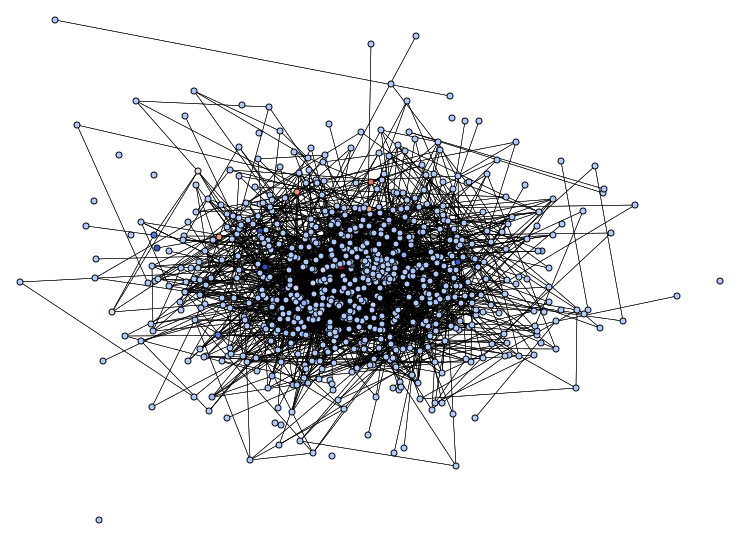

In [94]:
draw_graph(G['202210']['graph'], show_names=False, node_size=3)

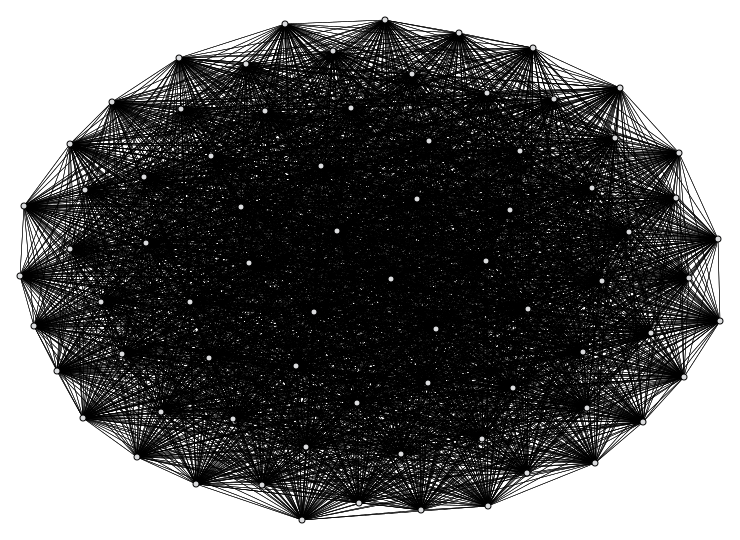

In [95]:
draw_graph(G['202210']['graph_core'], show_names=False, node_size=3)

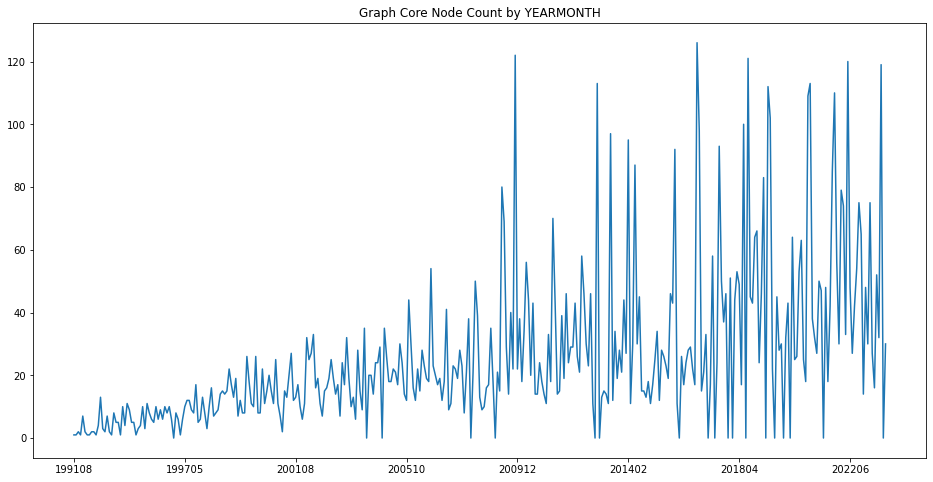

In [96]:
title = 'Graph Core Node Count by YEARMONTH'

_= result_df['graph_core_node_count'].plot(figsize=(16, 8), title=title)

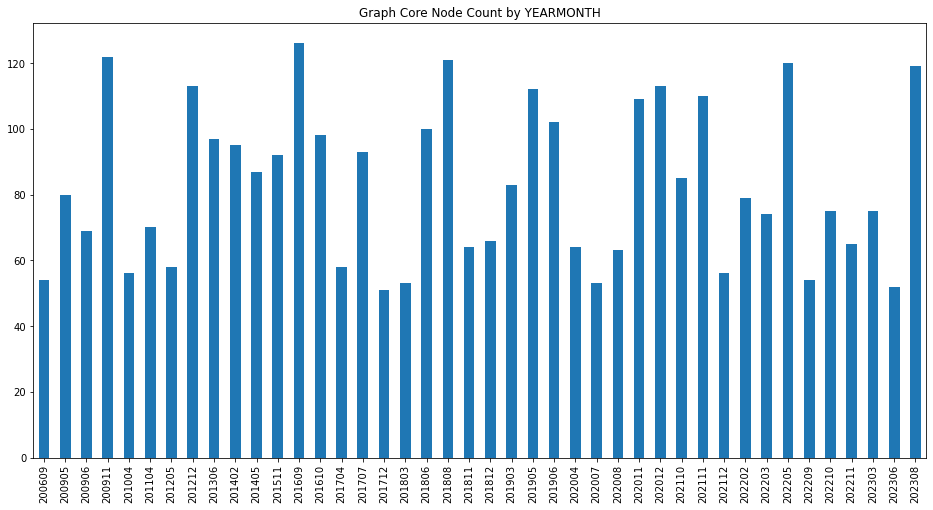

In [100]:
threshold = 50

result_df = result_df[result_df['graph_core_node_count']>threshold]

title = 'Graph Core Node Count by YEARMONTH'

_= result_df['graph_core_node_count'].plot.bar(figsize=(16, 8), title=title)

# Burstiness By Density Increase (EVERYBODY ARRIVED)

In [87]:
result_df = pd.DataFrame(G).T

result_df.head()

,graph,density_change,degree_change,edge_change,dropped_edges,added_edges,dropped_nodes,dropped_node_count,added_nodes,added_node_count,graph_dropped,graph_added,graph_core,graph_core_node_count,graph_core_edge_count
199108,(Donald E. Knuth),0,0,0,[],[],[],0,[],0,(),(),(Donald E. Knuth),1,0
199204,(Achi Brandt),0,0,0,[],[],[Donald E. Knuth],1,[Achi Brandt],1,(),(),(Achi Brandt),1,0
199205,"(M. Fabbrichesi, K. Roland)",1.0,1,1,[],"[(M. Fabbrichesi, K. Roland)]",[Achi Brandt],1,"[K. Roland, M. Fabbrichesi]",2,(),"(M. Fabbrichesi, K. Roland)","(M. Fabbrichesi, K. Roland)",2,1
199211,(Rolf Schimmrigk),-1.0,-1,-1,"[(M. Fabbrichesi, K. Roland)]",[],"[K. Roland, M. Fabbrichesi]",2,[Rolf Schimmrigk],1,"(M. Fabbrichesi, K. Roland)",(),(Rolf Schimmrigk),1,0
199302,"(D. Nunez, J. Salim, H. P. de Oliveira, A. Pov...",0.238095,6,5,[],"[(A. Poves, G. Martinez-Pinedo), (D. Nunez, H....",[Rolf Schimmrigk],1,"[A. D. Dolgov, A. Poves, D. Nunez, G. Martinez...",7,(),"(A. Poves, G. Martinez-Pinedo, D. Nunez, H. P....","(D. Nunez, J. Salim, H. P. de Oliveira, A. Pov...",7,5


In [88]:
result_df['density_change'][-20:] #small bug to fix on the last one, for another day

202204    -0.00183
202205    0.034756
202206   -0.034125
202207   -0.000088
202208   -0.002865
202209    0.007511
202210   -0.001453
202211   -0.007569
202212     0.00016
202301    0.000163
202302    0.001126
202303    0.005355
202304   -0.006539
202305   -0.001437
202306    0.004352
202307   -0.001395
202308     0.01193
202309   -0.012969
202310   -0.001433
202311         NaN
Name: density_change, dtype: object

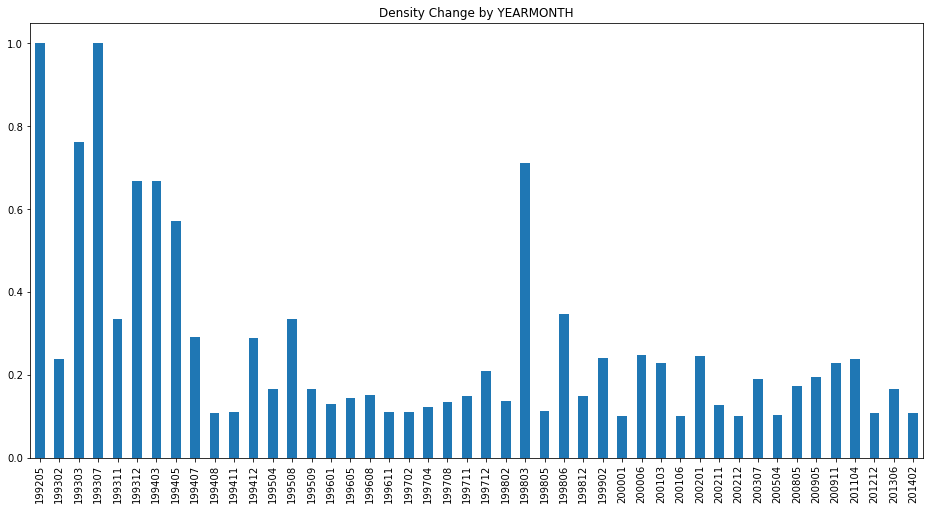

In [89]:
threshold = .1

result_df = result_df[result_df['density_change']>threshold]

title = 'Density Change by YEARMONTH'

_= result_df['density_change'].plot.bar(figsize=(16, 8), title=title)

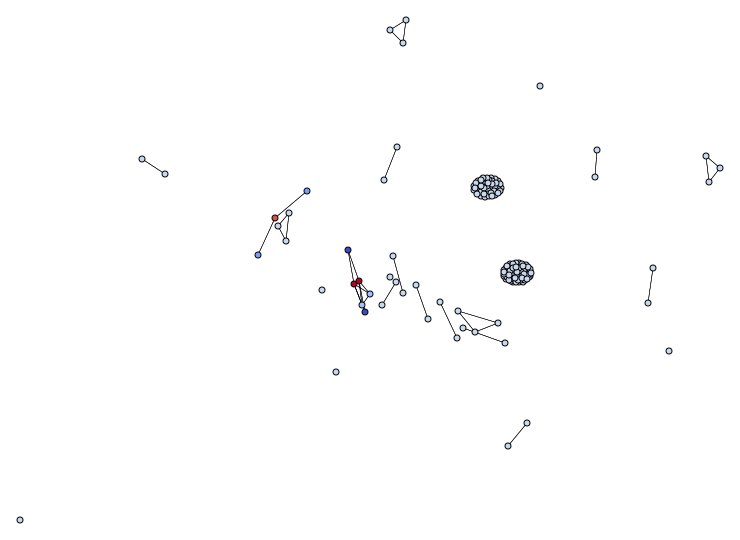

In [90]:
draw_graph(G['201104']['graph'], show_names=False, node_size=3)

# Burstiness By Density Decrease (EVERYBODY BOYCOTTED AND LEFT)

This can be done, too. But I will leave it for another day. Give it a try!

# Burstiness By Component Count

This can be done, too. But I will leave it for another day. Give it a try!